# Imports and Dependencies

In [2]:
import os
import glob
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from google.colab import drive

# Dataset Extraction and Path Configuration

In [3]:
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/dataset/absT.zip"
extract_path = "/content/absT"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

DATASET_DIR = os.path.join(extract_path, "absT")
MODEL_DIR = "/content/model"
OUTPUT_DIR = "/content/output"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, "train/images")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "train/labels")
VALID_IMAGE_DIR = os.path.join(DATASET_DIR, "valid/images")
VALID_LABEL_DIR = os.path.join(DATASET_DIR, "valid/labels")

Mounted at /content/drive


# Data Loading and Preprocessing

In [7]:
# Config
IMG_HEIGHT = 598
IMG_WIDTH = 96
NUM_CHANNELS = 3
NUM_CLASSES = 7
PATCH_SIZE = 16
EMBED_DIM = 256
NUM_HEADS = 8
MLP_DIM = 512
NUM_ENCODER_LAYERS = 6
DROPOUT_RATE = 0.2
L2_WEIGHT_DECAY = 1e-5
BATCH_SIZE = 32

class_names = ['annular', 'bubbly', 'churn', 'slug',
               'transition_bubbly-slug', 'transition_churn-annular',
               'transition_slug-churn']

TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, "train/images")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "train/labels")
VALID_IMAGE_DIR = os.path.join(DATASET_DIR, "valid/images")
VALID_LABEL_DIR = os.path.join(DATASET_DIR, "valid/labels")

def load_data(image_dir, label_dir):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.png")))
    label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))

    print(f"Checking image directory: {image_dir}")
    print(f"Found {len(image_paths)} images")
    print(f"Checking label directory: {label_dir}")
    print(f"Found {len(label_paths)} labels")

    if not label_paths:
        raise ValueError(f"No label files found in {label_dir}. Check the directory and file extensions.")

    if len(image_paths) != len(label_paths):
        print(f"Mismatch between images ({len(image_paths)}) and labels ({len(label_paths)})")
        min_length = min(len(image_paths), len(label_paths))
        image_paths = image_paths[:min_length]
        label_paths = label_paths[:min_length]

    def process_data(img_path, lbl_path):
        img = tf.io.read_file(img_path)
        is_jpg = tf.strings.regex_full_match(img_path, ".*\\.jpg")
        img = tf.cond(
            is_jpg,
            lambda: tf.image.decode_jpeg(img, channels=3),
            lambda: tf.image.decode_png(img, channels=3)
        )
        img.set_shape([None, None, 3])
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = tf.cast(img, tf.float32) / 255.0

        lbl_raw = tf.io.read_file(lbl_path)
        lbl_split = tf.strings.split(lbl_raw)
        lbl_id = tf.cond(
            tf.shape(lbl_split)[0] > 0,
            lambda: tf.strings.to_number(lbl_split[0], tf.float32),
            lambda: tf.constant(0.0, tf.float32)
        )
        lbl_id = tf.clip_by_value(lbl_id, 0, NUM_CLASSES - 1)
        lbl = tf.keras.utils.to_categorical(tf.cast(lbl_id, tf.int32), NUM_CLASSES)

        return img, lbl

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load and check datasets
print("Loading training dataset...")
train_dataset = load_data(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)

print("\nLoading validation dataset...")
valid_dataset = load_data(VALID_IMAGE_DIR, VALID_LABEL_DIR)

# Dataset check
for imgs, lbls in train_dataset.take(1):
    print("Train Image Batch Shape:", imgs.shape)
    print("Train Label Batch Shape:", lbls.shape)

for imgs, lbls in valid_dataset.take(1):
    print("Val Image Batch Shape:", imgs.shape)
    print("Val Label Batch Shape:", lbls.shape)

Loading training dataset...
Checking image directory: /content/absT/absT/train/images
Found 1921 images
Checking label directory: /content/absT/absT/train/labels
Found 1921 labels

Loading validation dataset...
Checking image directory: /content/absT/absT/valid/images
Found 411 images
Checking label directory: /content/absT/absT/valid/labels
Found 411 labels
Train Image Batch Shape: (32, 598, 96, 3)
Train Label Batch Shape: (32, 7)
Val Image Batch Shape: (32, 598, 96, 3)
Val Label Batch Shape: (32, 7)


# Transformer Custom Layers

In [8]:
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, data):
        batch_size = tf.shape(data)[0]
        padded_data = tf.pad(data, [[0, 0], [0, PATCH_SIZE], [0, PATCH_SIZE], [0, 0]])
        patches = tf.image.extract_patches(
            images=padded_data,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

class AddPositionEmbeddingPosition(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="cls_token"
        )
        self.pos_embed = self.add_weight(
            shape=(1, self.num_patches + 1, self.embed_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="pos_embed"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_tokens = tf.repeat(self.cls_token, batch_size, axis=0)
        return tf.concat([cls_tokens, inputs], axis=1) + self.pos_embed

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_patches + 1, self.embed_dim)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim": self.embed_dim
        })
        return config

# Transformer Neural Network Definition

In [9]:
# Layers
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        batch = tf.shape(images)[0]
        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch, -1, patch_dims])
        return patches

    def compute_output_shape(self, input_shape):
        b, h, w, c = input_shape
        n_h = h // self.patch_size
        n_w = w // self.patch_size
        return (b, n_h * n_w, self.patch_size * self.patch_size * c)

class ClassTokenPositional(layers.Layer):
    def __init__(self, embed_dim, n_patches, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.n_patches = n_patches

    def build(self, input_shape):
        self.class_token = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer="zeros",
            trainable=True
        )
        self.pos_embed = self.add_weight(
            shape=(1, self.n_patches + 1, self.embed_dim),
            initializer="random_normal",
            trainable=True
        )

    def call(self, x):
        b = tf.shape(x)[0]
        class_tok = tf.broadcast_to(self.class_token, [b, 1, self.embed_dim])
        x = tf.concat([class_tok, x], axis=1)
        return x + self.pos_embed

def transformer_encoder_block(x, embed_dim, num_heads, mlp_dim, dropout_rate):
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(y, y)
    y = layers.Dropout(dropout_rate)(y)
    x = layers.Add()([x, y])

    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(mlp_dim, activation="gelu", kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(y)
    y = layers.Dropout(dropout_rate)(y)
    y = layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(y)
    y = layers.Dropout(dropout_rate)(y)
    x = layers.Add()([x, y])
    return x

# Build model
def build_tnn_model():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))

    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    patches = PatchExtract(PATCH_SIZE)(x)
    projected = layers.Dense(EMBED_DIM)(patches)

    n_patches = projected.shape[1]
    x = ClassTokenPositional(EMBED_DIM, n_patches)(projected)

    for _ in range(NUM_ENCODER_LAYERS):
        x = transformer_encoder_block(x, EMBED_DIM, NUM_HEADS, MLP_DIM, DROPOUT_RATE)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Lambda(lambda t: t[:, 0])(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return models.Model(inputs, outputs)

# Compile
model = build_tnn_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 598, 96,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 598, 96,   │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 598, 96,   │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 299, 48,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 299, 48,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 149, 24,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 149, 24,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extract       │ (None, 9, 32768)  │          0 │ conv2d_2[0][0]    │
│ (PatchExtract)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 9, 256)    │  8,388,864 │ patch_extract[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_token_positi… │ (None, 10, 256)   │      2,816 │ dense[0][0]       │
│ (ClassTokenPositio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 256)   │        512 │ class_token_posi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 256)   │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 256)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 256)   │          0 │ class_token_posi… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 256)   │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 512)   │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 512)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10, 256)   │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,649,863 (44.44 MB)

 Trainable params: 11,649,863 (44.44 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [10]:
train_ds = train_dataset.shuffle(1024).prefetch(tf.data.AUTOTUNE)
val_ds = valid_dataset.prefetch(tf.data.AUTOTUNE)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("best_tnn_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
]

# Fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.1490 - loss: 3.3695 - precision: 0.1526 - recall: 0.0964
Epoch 1: val_accuracy improved from -inf to 0.14599, saving model to best_tnn_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 88s 583ms/step - accuracy: 0.1488 - loss: 3.3685 - precision: 0.1524 - recall: 0.0961 - val_accuracy: 0.1460 - val_loss: 2.3223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1264 - loss: 2.8765 - precision: 0.1202 - recall: 0.0463
Epoch 2: val_accuracy did not improve from 0.14599
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.1267 - loss: 2.8753 - precision: 0.1205 - recall: 0.0465 - val_accuracy: 0.1460 - val_loss: 2.2280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1220 - loss: 2.7818 - precision: 0.1116 - recall: 0.0370
Epoch 3: val_accu

# Training Metrics Visualization

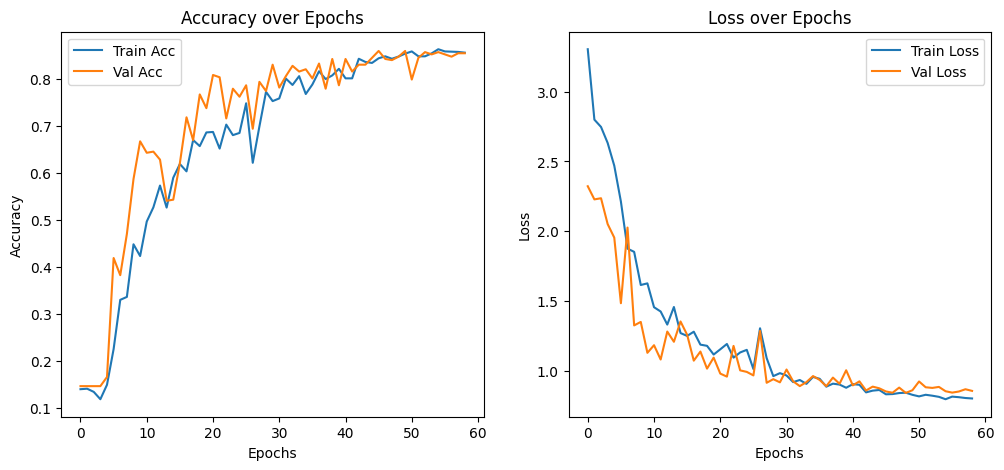

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()

y_train_true, y_train_pred = [], []
for batch_images, batch_labels in train_dataset:
    train_probs = model.predict(batch_images)
    y_train_true.extend(np.argmax(batch_labels.numpy(), axis=1))
    y_train_pred.extend(np.argmax(train_probs, axis=1))

train_acc = accuracy_score(y_train_true, y_train_pred)

y_val_true, y_val_pred = [], []
for batch_images, batch_labels in valid_dataset:
    val_probs = model.predict(batch_images)
    y_val_true.extend(np.argmax(batch_labels.numpy(), axis=1))
    y_val_pred.extend(np.argmax(val_probs, axis=1))

val_acc = accuracy_score(y_val_true, y_val_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Overall Validation Accuracy: {val_acc:.4f}")

# Model Saving

In [13]:
model_path = os.path.join(MODEL_DIR, 'tnn_mpfp5.keras')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /content/model/tnn_mpfp5.keras
